In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import yfinance as yf
from dateutil.relativedelta import relativedelta
import datetime as dt
import pandas_ta as ta

In [48]:
# Load the stock data
ticker = 'AAPL'
period = 1
end = None

if end is None:
    end = dt.date.today()
start = end - relativedelta(years=period)

stock_data = pd.DataFrame(yf.download(ticker, start=start, end=end)) # Get Adj Close price and store in dataframe

# Reset index to convert the date index into a column
stock_data.reset_index(inplace=True)

# Adding day of the week as a temporal feature (0=Monday, 4=Friday)
stock_data['Day of Week'] = stock_data['Date'].dt.dayofweek

# Calculate moving averages using pandas_ta
stock_data['MA_5'] = ta.ma('sma', stock_data['Adj Close'], length=5)
stock_data['MA_10'] = ta.ma('sma', stock_data['Adj Close'], length=10)

# Calculate RSI using pandas_ta
stock_data['RSI'] = ta.rsi(stock_data['Adj Close'], length=14)

# Creating lagged features for the Adj Close prices
for i in range(1, 6):
    stock_data[f'Adj Close Lag {i}'] = stock_data['Adj Close'].shift(i)

# Use the Adj Close price as the target variable and shift by -1 to predict the next day's price
stock_data['Next Day Adj Close'] = stock_data['Adj Close'].shift(-1)

# Drop rows with NaN values that are the result of lagged features and technical indicators calculation
stock_data.dropna(inplace=True)

# Drop the last row since it will have a NaN value for 'Next Day Close'
stock_data = stock_data[:-1]

print(stock_data)


[*********************100%%**********************]  1 of 1 completed
          Date        Open        High         Low       Close   Adj Close  \
14  2023-03-07  153.699997  154.029999  151.130005  151.600006  150.795120   
15  2023-03-08  152.809998  153.470001  151.830002  152.869995  152.058365   
16  2023-03-09  153.559998  154.539993  150.229996  150.589996  149.790466   
17  2023-03-10  150.210007  150.940002  147.610001  148.500000  147.711563   
18  2023-03-13  147.809998  153.139999  147.699997  150.470001  149.671112   
..         ...         ...         ...         ...         ...         ...   
244 2024-02-05  188.149994  189.250000  185.839996  187.679993  187.440811   
245 2024-02-06  186.860001  189.309998  186.770004  189.300003  189.058762   
246 2024-02-07  190.639999  191.050003  188.610001  189.410004  189.168625   
247 2024-02-08  189.389999  189.539993  187.350006  188.320007  188.080017   
248 2024-02-09  188.649994  189.990005  188.000000  188.850006  188.85000

In [49]:
# Define feature columns excluding 'Date' and target columns
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Day of Week', 'MA_5', 'MA_10', 'RSI'] + [f'Adj Close Lag {i}' for i in range(1, 6)]

# Define the feature and target variables
X = stock_data[feature_columns]  # features
y = stock_data['Next Day Adj Close']  # target

# Split the stock data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
# Initialize the model
model = LinearRegression()

# Fit the model on the training stock_data
model.fit(X_train, y_train)


LinearRegression()

Mean Squared Error: 5.229097404680899


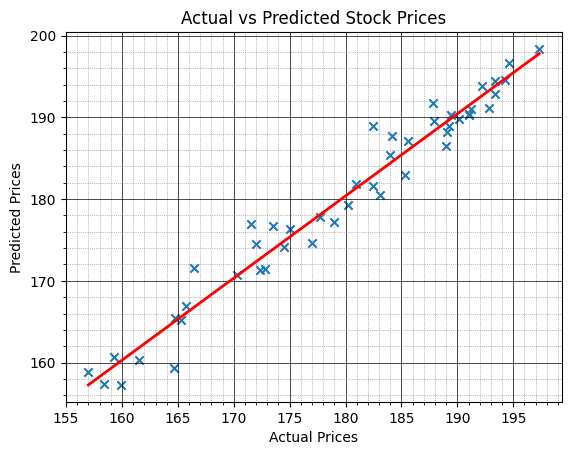

In [51]:
# Predict the 'Next Day Close' for the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the predictions against the actual values
plt.scatter(y_test, y_pred, marker='x')

# Calculate coefficients for the line of best fit
coefficients = np.polyfit(y_test, y_pred, 1)
polynomial = np.poly1d(coefficients)
# Generate y_fit values across the actual y_test range
y_fit = polynomial(np.sort(y_test))

# Ensure y_test is sorted for the line plot
sorted_y_test = np.sort(y_test)

plt.plot(sorted_y_test, y_fit, color='red', linewidth=2)  # Line of best fit

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Stock Prices")

# Enable grid and set to major and minor lines with different linestyles
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()

plt.show()


In [59]:
def prepare_features_for_prediction(stock_data):
    appended_data = stock_data[-max(10, 14):].copy()  # Adjust based on max lag and indicator periods
    
    # Calculate indicators
    appended_data['MA_5'] = ta.sma(appended_data['Adj Close'], length=5)
    appended_data['MA_10'] = ta.sma(appended_data['Adj Close'], length=10)
    appended_data['RSI'] = ta.rsi(appended_data['Adj Close'], length=14)
    
    # Ensure all NaN values are filled. For demonstration, we fill NaNs with the last non-NaN value.
    appended_data.fillna(method='ffill', inplace=True)
    appended_data.fillna(method='bfill', inplace=True)  # In case the first values are NaN
    
    feature_dict = {
        'Open': appended_data['Open'].iloc[-1],
        'High': appended_data['High'].iloc[-1],
        'Low': appended_data['Low'].iloc[-1],
        'Close': appended_data['Close'].iloc[-1],
        'Volume': appended_data['Volume'].iloc[-1],
        'Day of Week': appended_data['Date'].dt.dayofweek.iloc[-1],
        'MA_5': appended_data['MA_5'].iloc[-1],
        'MA_10': appended_data['MA_10'].iloc[-1],
        'RSI': appended_data['RSI'].iloc[-1],
    }

    # Adding lagged features for Adj Close
    for i in range(1, 6):
        feature_dict[f'Adj Close Lag {i}'] = appended_data['Adj Close'].iloc[-i]
    
    features_df = pd.DataFrame([feature_dict])
    
    # Assuming 'feature_columns' is defined with the correct order
    features_df = features_df[feature_columns]
    
    # Final check to replace any remaining NaNs with zeros or another default value
    features_df.fillna(0, inplace=True)
    
    return features_df

In [60]:
# Prepare features for prediction
features_for_prediction = prepare_features_for_prediction(stock_data)

# Predict the next day's closing price
predicted_next_day_close = model.predict(features_for_prediction)

print(f"Predicted next day's adjusted closing price: {predicted_next_day_close[0]}")

Predicted next day's adjusted closing price: 185.7788707609733


C:\Users\ggrif\AppData\Local\Temp\ipykernel_18728\4098165926.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  appended_data.fillna(method='ffill', inplace=True)
C:\Users\ggrif\AppData\Local\Temp\ipykernel_18728\4098165926.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  appended_data.fillna(method='bfill', inplace=True)  # In case the first values are NaN
